# Simple PINN for an elastic plate with a hole 

## Represent geometry

We represent the geometry by a set of collocation points 

radius x-axis:  0.3
radius y-axis:  0.8333333333333334


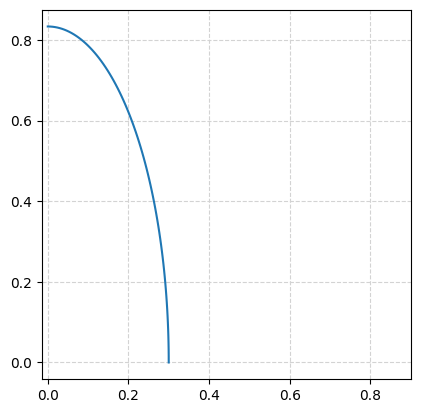

2
4
22


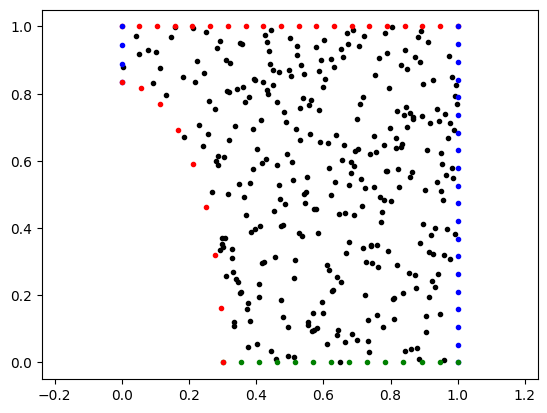

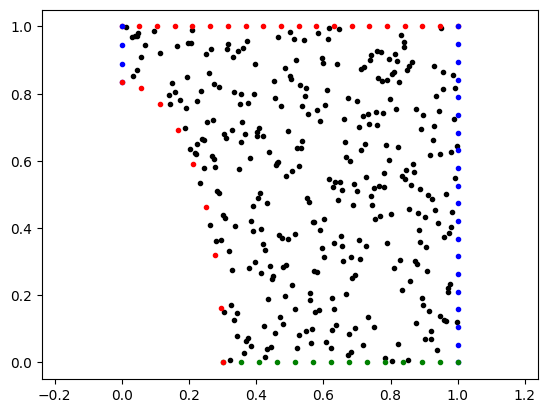

'\nprint("one plate")\nprint(data_train_points)\nprint("multiple plates")\nprint(multiple_plates_data)\n\na = [points[1] for points in multiple_plates_data]\nprint("one plate")\n#print(data_train_points)\nprint("multiple plates")\ncollo_points = [points[:2] for points in multiple_plates_data]\nboundary_points = [points for points in multiple_plates_data]\n'

In [109]:
import torch
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import random
from math import pi, ceil
from plate_elliptic_hole import Plate 

# Applied strain at right boundary
EPS0 = 0.1
# Applied body force field
B0 = 0.0
# Lame constants
MU = 1
LBD = 2

Re_x = 0.3 #radius on the x-axis of the ellipse 
SuAr= 0.25*pi   #surface area of the eclipse (= equal to SuAr of a circle with R=0.5)
L = 1 #length of plate #info: muss noch gefixt werden -> momentan bei 1 lassen
N = 20 #number of collocation Point in x-axis direction
P = 2 #number of plates in dataset
NN = ceil(N * (L-Re_x)/L) #number of collocation Point in both direction


def generate_multiple_plates2(iteration):
    data_points = []
    for i in range(iteration):
        p1 = Plate(Re_x, SuAr, L, N)
        data_one_plate = p1.generate_dataset(Re_xnew, Re_ynew, L, N)
        dict_plate_points =  {"x_collo": data_one_plate[0][0], "y_collo": data_one_plate[0][1], "x_top": data_one_plate[1][0], 
                        "y_top":data_one_plate[1][1], "x_right":data_one_plate[1][2], "y_right":data_one_plate[1][3],
                          "x_left":data_one_plate[1][4], "y_left":data_one_plate[1][5], "x_bottom":data_one_plate[1][6],
                            "y_bottom":data_one_plate[1][7], "x_hole":data_one_plate[1][8], 
                            "y_hole":data_one_plate[1][9], "n_hole":data_one_plate[1][10]}
        #p1.plot_plate_with_hole(*data_one_plate)
        data_points.append(dict_plate_points)
        print(data_points)
    return data_points

def generate_multiple_plates(iteration):
    data_points = []
    for i in range(iteration):
        p1 = Plate(Re_x, SuAr, L, N)
        data_one_plate = p1.generate_dataset(Re_xnew, Re_ynew, L, N)
        #p1.plot_plate_with_hole(*data_one_plate)
        data_points.append(data_one_plate)
    return data_points


p2 = Plate(Re_x, SuAr, L, N)
Re_xnew, Re_ynew = p2.create_ellipse(Re_x,SuAr, L)
p2.plot_quarter_elli(Re_xnew, Re_ynew)
data_train_points = p2.generate_dataset(Re_xnew, Re_ynew, L, N)
data_test_points = p2.generate_dataset_test(Re_xnew, Re_ynew, L, N)
multiple_plates_data = generate_multiple_plates(P)
print(len(multiple_plates_data))
collo_points = [subpoints for points in multiple_plates_data for subpoints in points[0]]
boundary_points = [subpoints for points in multiple_plates_data for subpoints in points[1]]


print(len(collo_points))
print(len(boundary_points))
p2.plot_plate_with_hole(*data_train_points)
p2.plot_plate_with_hole(*data_test_points)
"""
print("one plate")
print(data_train_points)
print("multiple plates")
print(multiple_plates_data)

a = [points[1] for points in multiple_plates_data]
print("one plate")
#print(data_train_points)
print("multiple plates")
collo_points = [points[:2] for points in multiple_plates_data]
boundary_points = [points for points in multiple_plates_data]
"""



In [105]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hn = 20
        self.hidden_layer1 = torch.nn.Linear(2,hn)
        self.hidden_layer2 = torch.nn.Linear(hn,hn)
        self.hidden_layer3 = torch.nn.Linear(hn,hn)
        self.hidden_layer4 = torch.nn.Linear(hn,hn)
        self.hidden_layer5 = torch.nn.Linear(hn,hn)
        self.output_layer = torch.nn.Linear(hn,2)

    def forward(self, x, y):
        inputs = torch.column_stack([x, y])
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the PDE 
$$
    \nabla \cdot \sigma - \mathbf{b} = \mathbf{0}. 
$$

In [106]:
def sigma(eps):
    I = torch.eye(2)
    return 2.0 * MU * eps + LBD * torch.einsum("...ii,...jk->...jk", eps, I)

def epsilon(x, y, net):
    disp = net(x, y)
    u = disp[:,0]
    v = disp[:,1]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]

    gradx = torch.column_stack([u_x, v_x])
    grady = torch.column_stack([u_y, v_y])
    gradient = torch.stack([gradx, grady], dim=2)

    return 0.5 * (gradient + torch.transpose(gradient, 1, 2))

def pde_residual(x, y, net):
    stress = sigma(epsilon(x,y, net))
    sxx = stress[:,0,0]
    sxy = stress[:,0,1]
    syx = stress[:,1,0]
    syy = stress[:,1,1]
    

    sxx_x = torch.autograd.grad(sxx.sum(), x, create_graph=True)[0]
    sxy_y = torch.autograd.grad(sxy.sum(), y, create_graph=True)[0]
    syx_x = torch.autograd.grad(syx.sum(), x, create_graph=True)[0]
    syy_y = torch.autograd.grad(syy.sum(), y, create_graph=True)[0]

    residual_x = sxx_x + sxy_y - B0
    residual_y = syx_x + syy_y
    return residual_x, residual_y


## The loss function

In [107]:
W_PDE = 0.01
W_NEUMANN = 0.01

mse = torch.nn.MSELoss()


def compute_loss(net,x_collo, y_collo, x_top, y_top, x_right, y_right, x_left, y_left, x_bottom, y_bottom, x_hole, y_hole, n_hole):
    # pde
    res_x, res_y = pde_residual(x_collo, y_collo, net)
    zeros = torch.zeros_like(res_x)
    pde_error = mse(res_x, zeros) + mse(res_y, zeros)

    # left boundary
    pred_left = net(x_left, y_left)
    bc_left = torch.zeros_like(pred_left[:,0])
    left_error = mse(pred_left[:,0], bc_left) 

    # right boundary
    pred_right = net(x_right, y_right)
    bc_right = EPS0 * L * torch.ones_like(pred_right[:,0])
    right_error = mse(pred_right[:,0], bc_right) 

    # bottom boundary
    pred_bottom = net(x_bottom, y_bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:,1])
    bottom_error = mse(pred_bottom[:,1], bc_bottom) 

    # top boundary
    stress_top = sigma(epsilon(x_top, y_top, net))
    zeros = torch.zeros_like(stress_top[:,1,1])
    top_error = mse(stress_top[:,1,1], zeros) + mse(stress_top[:,0,1], zeros)

    # hole boundary
    stress_hole = sigma(epsilon(x_hole, y_hole, net))
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:,0])
    hole_error = mse(traction[:,0], zeros) + mse(traction[:,1], zeros)

    return (
        left_error
        + right_error
        + bottom_error
        + W_NEUMANN * top_error
        + W_NEUMANN * hole_error
        + W_PDE * pde_error
    )


## Training 

In [108]:
net = Net()
train_data = []
test_data = []

print("Starting with Adam optimizer for 4000 epoch...")
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
for epoch in range(4000):
    optimizer.zero_grad()
    # old code 
    # loss_train = compute_loss(net, *data_train_points[0], *data_train_points[1])
    # new code
    collo_points = [subpoints for points in multiple_plates_data for subpoints in points[0]]
    boundary_points = [subpoints for points in multiple_plates_data for subpoints in points[1]]
    loss_train = compute_loss(net, *collo_points, *boundary_points)
    loss_train.backward(retain_graph=True)
    optimizer.step()
    with torch.autograd.no_grad():
        train_data.append(float(loss_train.data))
        test_data.append(float(loss_test.data))

print("Switching to LBFGS optimizer for 1000 epoch for fine tuning...")
optimizer = torch.optim.LBFGS(net.parameters())
for epoch in range(1000):
    def closure():
        optimizer.zero_grad()
        loss_train = compute_loss(net, *data_train_points[0], *data_train_points[1])
        loss_test = compute_loss(net, *data_test_points[0], *data_test_points[1])
        loss_train.backward(retain_graph=True)
        with torch.autograd.no_grad():
            train_data.append(float(loss_train.data))
            test_data.append(float(loss_test.data))
        return loss_train
    optimizer.step(closure)
        
plt.plot(train_data, c='g', label='train', linewidth=5.0)
plt.plot(test_data, c='r', label='test')
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()




Starting with Adam optimizer for 4000 epoch...


TypeError: compute_loss() takes 14 positional arguments but 53 were given

## Visualization of results

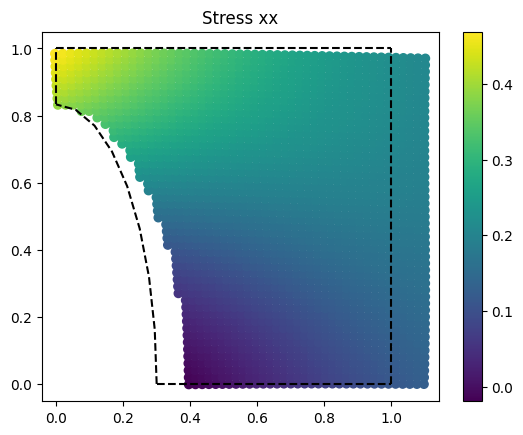

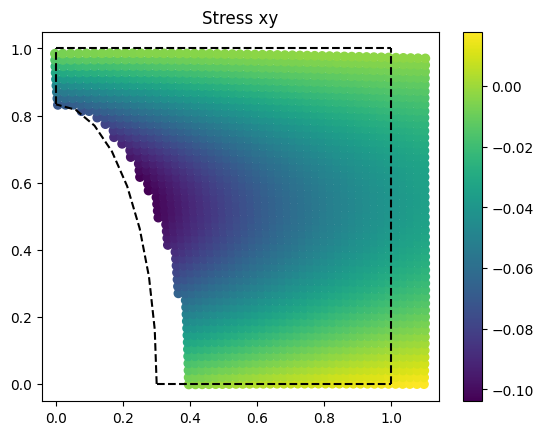

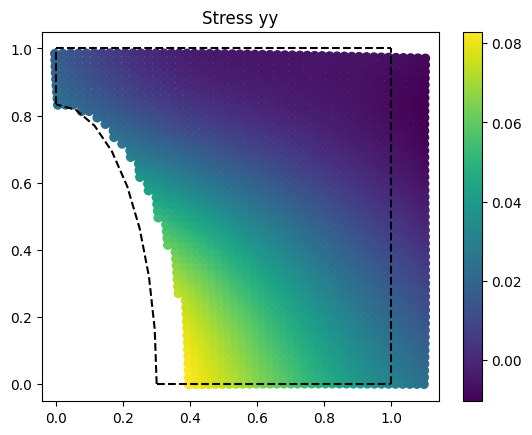

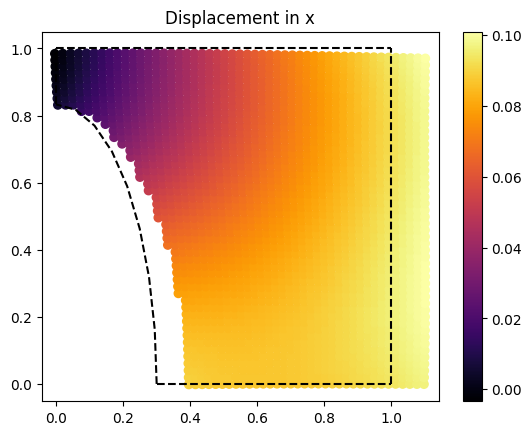

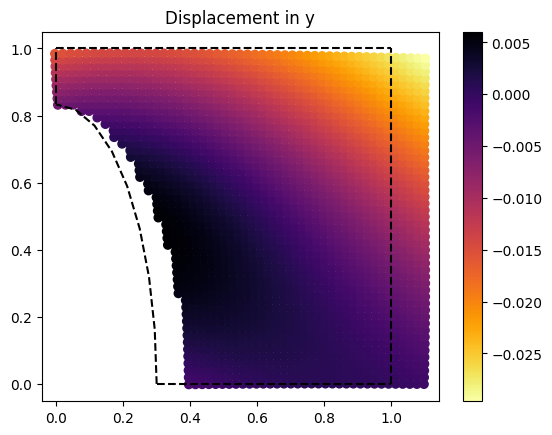

In [ ]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T
val_domain = val_domain[((val_domain[:,0] ** 2)/(Re_xnew**2)) + ((val_domain[:,1] ** 2)/(Re_ynew**2)) > 1]
val_x = torch.tensor(val_domain[:,0], requires_grad=True).float()
val_y = torch.tensor(val_domain[:,1], requires_grad=True).float()

# Compute model predictions on the validation domain
disp = net(val_x, val_y).detach()
def_val_x = val_x.detach() + disp[:, 0]
def_val_y = val_y.detach()+ disp[:, 1]
strain = epsilon(val_x, val_y, net).detach()
stress = sigma(strain).detach()
residual_x, residual_y = pde_residual(val_x, val_y, net)

def make_plot(variable, title, boundary_points, **kwargs):
    plt.plot(boundary_points[0].detach(), boundary_points[1].detach(), "--k")
    plt.plot(boundary_points[2], boundary_points[3], "--k")
    plt.plot(boundary_points[4], boundary_points[5], "--k")
    plt.plot(boundary_points[6], boundary_points[7], "--k")
    plt.plot(boundary_points[8].detach(), boundary_points[9].detach(), "--k")
    plt.scatter(def_val_x, def_val_y, c=variable, **kwargs)
    plt.axis("equal")
    plt.colorbar()
    plt.title(title)
    plt.show()

make_plot(stress[:, 0, 0], "Stress xx", data_test_points[1])
make_plot(stress[:, 0, 1], "Stress xy", data_test_points[1])
make_plot(stress[:, 1, 1], "Stress yy", data_test_points[1])
make_plot(disp[:, 0], "Displacement in x",data_test_points[1], cmap="inferno",)
make_plot(disp[:, 1], "Displacement in y", data_test_points[1], cmap="inferno_r")



In [ ]:
class Plate:
    def __init__(self, Re_x, SuAr, L, N):
        self.Re_x = Re_x
        self.SuAr = SuAr
        self.Re_y = SuAr/(pi*Re_x) 
        self.L = L
        self.N = N
        self.NN = ceil(N * (L-Re_x)/L)
        self.collopoints = None

    def create_ellipse(self, Re_x, SuAr, max_length):
        while True:
            Re_y=  SuAr/(pi*Re_x)   #radius on the y-axis
            if (Re_x>max_length or Re_x<0):
                print("x_radius was not in range between 0 and max_length")
                Re_x = random.random()* max_length
                continue
            if (Re_y>max_length or Re_y<0):
                print("y_radius was not in range between 0 and max_length")
                continue
            else: break
        print("radius x-axis: ",Re_x)
        print("radius y-axis: ",Re_y)
        return Re_x,Re_y
    
    def plot_ellipse(self, Re_x, Re_y):
        t = np.linspace(0, 2*pi, 80)
        plt.plot( Re_x*np.cos(t) , Re_y*np.sin(t) )
        plt.axis('square')
        plt.grid(color='lightgray',linestyle='--')
        plt.show()


    def plot_quarter_elli(self, Re_x, Re_y):
        t = np.linspace(0, 0.5*pi, 80)
        plt.plot( Re_x*np.cos(t) , Re_y*np.sin(t) )
        plt.axis('square')
        plt.grid(color='lightgray',linestyle='--')
        plt.show()

    def generate_dataset(self, Re_x, Re_y, L, N):
        # Create collocation points
        points = L * qmc.LatinHypercube(d=2).random(N**2)

        #excludes points that are inside the elliptical hole
        points = points[(((points[:,0] ** 2)/(Re_x**2)) + ((points[:,1] ** 2)/(Re_y**2))) > 1]
        x_collocation = torch.tensor(points[:,0], requires_grad=True).float()
        y_collocation = torch.tensor(points[:,1], requires_grad=True).float()
        collo_points = [x_collocation, y_collocation]
        # Boundaries
        x_top = torch.linspace(0, L, N, requires_grad=True)
        y_top = L * torch.ones((N, 1), requires_grad=True)

        x_right = L * torch.ones((N, 1))
        y_right = torch.linspace(0, L, N)

        x_left = torch.zeros(ceil(N*(1-Re_y)), 1)
        y_left = torch.linspace(Re_y, L, ceil(N*(1-Re_y)))

        x_bottom = torch.linspace(Re_x, L, ceil(N*(1-Re_x)))
        y_bottom = L * torch.zeros(ceil(N*(1-Re_x)), 1)

        phi = np.linspace(0, 0.5 * np.pi, int(N * 0.5 * np.pi * Re_x / L))
        x_hole = torch.tensor(Re_x * np.cos(phi), requires_grad=True).float()
        y_hole = torch.tensor(Re_y * np.sin(phi), requires_grad=True).float()

        n_hole = torch.tensor(np.stack([-np.cos(phi), -np.sin(phi)]).T).float()
        boundary_points= [x_top, y_top, x_right, y_right, x_left, y_left, x_bottom, y_bottom, x_hole, y_hole, n_hole]

        return collo_points, boundary_points

    def plot_plate_with_hole(self, collo_points, boundary_points):
        # Visualize geometry (Dirichlet blue, Neumann red)
        plt.plot(collo_points[0].detach(), collo_points[1].detach(), ".k")
        plt.plot(boundary_points[0].detach(), boundary_points[1].detach(), ".r")
        plt.plot(boundary_points[6], boundary_points[7], ".g")
        plt.plot(boundary_points[4], boundary_points[5], ".b")
        plt.plot(boundary_points[2], boundary_points[3], ".b")
        plt.plot(boundary_points[8].detach(), boundary_points[9].detach(), ".r")
        plt.axis("equal")
        plt.show()